In [1]:
using Plots
using KernelDensity


include("distributions.jl")



generate_prob_measures (generic function with 1 method)

In [2]:
n = 2
m = 500
t_1, t_2 = tnormal_normal(0.0), tnormal_normal(0.5)
pms_1, pms_2 = generate_prob_measures(t_1, n), generate_prob_measures(t_2, n)
emp_1, emp_2 = generate_emp(pms_1, n,m), generate_emp(pms_2, n,m)

(emp_ppm([-2.257906029168594 0.6990199815049499 … 0.9625186366861125 -0.2728155656094804; -0.9843994262217798 0.07425434966144961 … -0.4602387473091266 1.4091328317163643], 2, 500, -2.6398046665341313, 3.8790341620818714), emp_ppm([-0.9852819602393244 0.5863778355690246 … -0.2825247692382822 -1.536130228022076; 0.8290318315477125 -0.040976470910222135 … 0.6352774137779231 1.0773328384362666], 2, 500, -2.5715917585694736, 3.440388894096495))

compare true density to the density from observations



In [3]:
plot_densities = plot()
xrange = collect(-4.0:0.01:4.0)
hier_sample_1 = generate_emp(pms_1, n, m)
for i in 1:length(pms_1)
    d = pms_1[i]  # standard normal (mean 0, std 1)
    μ = d.μ
    plot!(plot_densities, xrange, pdf(d, xrange), label="mean = $(μ)", xlabel="x", ylabel="Density")
    kde_est = kde(hier_sample_1.atoms[i, :])
    plot!(plot_densities, xrange, pdf(kde_est, xrange), label="kde,mean = $(μ)", xlabel="x", ylabel="kernel Density")
end



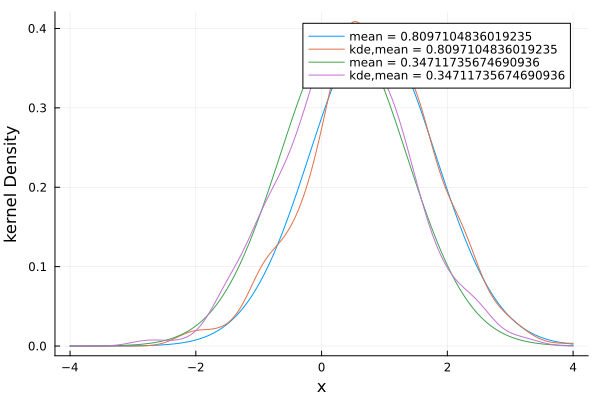

In [4]:
plot_densities

Now let us write the testing scheme for DUBEY and MÜLLER that decides whether to reject null or not.

In [5]:
function test_statistic_dm(pms_1::Vector{Normal}, pms_2::Vector{Normal})
    # given two samples of probobability measures, compute the test statistic according to Dubey & Muller
    n = length(pms_1)
    # Recall that we assume that each of the sample is Normal distribution, and for W_2 metric we only need their means.
    X = [pms_1[i].μ for i in 1:n] # collect all the means from first samples of probability measures
    Y = [pms_2[i].μ for i in 1:n] # collect all the means from second samples of probability measures
    
    μ_hat_1 = mean(X)
    μ_hat_2 = mean(Y)

    v_hat_1 = mean((X .- μ_hat_1).^2)
    v_hat_2 = mean((Y .- μ_hat_2).^2)

    σ_hat_1_squared = mean((X .- μ_hat_1).^4) - (v_hat_1)^2
    σ_hat_2_squared = mean((Y .- μ_hat_2).^4) - (v_hat_2)^2
    
    μ_hat_p = sum(X .+ Y) / (2 * n)
    v_hat_p = sum( (X .- μ_hat_p).^2 .+ (Y .- μ_hat_p).^2 ) / (2 * n)

    F_n = v_hat_p - v_hat_1/2 - v_hat_2/2
    U_n = (1/4) * ((v_hat_1 - v_hat_2)^2) / (σ_hat_1_squared * σ_hat_2_squared) 
    
    T_n = 2*n*U_n / (1/(2*σ_hat_1_squared) + 1/(2*σ_hat_2_squared) ) + 2 * n * (F_n^2) / (σ_hat_1_squared/4 + σ_hat_2_squared/4)

    return T_n
end




test_statistic_dm (generic function with 1 method)

In [6]:
function decide_dm_asympt(pms_1::Vector{Normal}, pms_2::Vector{Normal}, n_boostrap::Int, θ = 0.05)
    # given two samples of probobability measures, this function returns 0 or 1, i.e. either rejects or accepts 
    # null hypothesis for given significance level θ according to Dubey & Muller.

    # threshold is choosen from asymptotic distribution of test statistic which is chi-squared.

    n_top = length(pms_1)
    T_n = test_statistic_dm(pms_1, pms_2) # test statistic
    
    threshold = quantile(Chisq(1), 1 - θ) # obtain quantile from asymptotic distribution of test statistic
    decision = 1.0*(T_n > threshold) # 1.0 if T_n > threshold, 0.0 otherwise.
    return decision
end

function decide_dm_boostrap(pms_1::Vector{Normal}, pms_2::Vector{Normal}, n_boostrap::Int, θ = 0.05)
    # given two samples of probobability measures, this function returns 0 or 1, i.e. either rejects or accepts 
    # null hypothesis for given significance level θ according to Dubey & Muller.

    # n_boostrap: number of times we repeat bootstrap procedure to estimate the quantile of the test statistic

    n_top = length(pms_1)
    T_n = test_statistic_dm(pms_1, pms_2) # test statistic
    # obtain quantile using bootstrap approach
    T_n_boostrap = zeros(n_boostrap)
    for s in 1:n_boostrap
        allmeasures = vcat(pms_1, pms_2) # collect all probability measures into one vector
        pms_1_boostrap = sample(allmeasures, n_top; replace=true) # resample from pooled probability measures
        pms_2_boostrap = sample(allmeasures, n_top; replace=true) # resample from pooled probability measures
        T_n_boostrap[s] = test_statistic_dm(pms_1_boostrap, pms_2_boostrap) # test statistic from boostraped sample
    end
    threshold = quantile(T_n_boostrap, 1-θ)
    decision = 1.0*(T_n > threshold) # 1.0 if T_n > threshold, 0.0 otherwise.
    return decision
end


decide_dm_boostrap (generic function with 2 methods)

In [7]:
function rejection_rate(q_1::PPM, q_2::PPM, S::Int, n_top::Int, n_bottom::Int, n_boostrap::Int, θ::Float64)
    # Given two laws of RPM, q_1 and q_2, estimate the rejection rate for given significance level θ for 3 testing schemes:
    # Dubey & Mueller, HIPM, WoW

    # S : number of times we simulate two samples from given laws of RPM
    # n_top : number of probability measures we simulate from each q
    # n_bottom : number of random variables we simulate from each of the probability measure from q
    # n_boostrap : number of times we repeat bootstrap procedure to estimate the quantile of the test statistic
    
    rej_rate_dm, rej_rate_hipm, rej_rate_wow = 0.0, 0.0, 0.0

    for s in 1:S
        pms_1, pms_2 = generate_prob_measures(q_1, n_top), generate_prob_measures(q_2, n_top) # generate n_top probability measures
                                            # from q_1 and q_2
        hier_sample_1, hier_sample_2 = generate_emp(pms_1, n_top, n_bottom), generate_emp(pms_2, n_top, n_bottom) # generate n_bottom
                                            # random variables from each probability measures in pms_1 and pms_2

        # record if testing schemes reject
        rej_rate_dm += decide_dm_boostrap(pms_1, pms_2, n_boostrap, θ)
        #rej_rate_hipm += decide_hipm(hier_sample_1, hier_sample_2, n_boostrap, θ)
        #rej_rate_wow += decide_wow(hier_sample_1, hier_sample_2, n_boostrap, θ)
    end
    rej_rate_dm /= S
    rej_rate_hipm /= S
    rej_rate_wow /= S
    return rej_rate_dm, rej_rate_hipm, rej_rate_wow
end


rejection_rate (generic function with 1 method)

In [8]:
function power_dm(δ::Float64, n_top::Int, n_boostrap::Int, S::Int, θ::Float64)
    # given δ, defines two laws of RPM as defined in the paper of Dubey & Muller and returns the rejection rate
    q_1, q_2 = tnormal_normal(0.0), tnormal_normal(δ)
    rej_rate_dm, rej_rate_hipm, rej_rate_wow = rejection_rate(q_1, q_2, S, n_top, n_bottom, n_boostrap, θ)
    return rej_rate_dm
end

function power_dm(δs::Vector{Float64}, n_top::Int, n_boostrap::Int, S::Int, θ::Float64)
    # given δs, defines two laws of RPM as defined in the paper of Dubey & Muller and returns the rejection rate per each δ
    rej_rates_dm = zeros(length(δs))

    for i in 1:length(δs)
        q_1, q_2 = tnormal_normal(0.0), tnormal_normal(δs[i])
        rej_rate_dm, rej_rate_hipm, rej_rate_wow = rejection_rate(q_1, q_2, S, n_top, n_bottom, n_boostrap, θ)

        rej_rates_dm[i] = rej_rate_dm
    end
    return rej_rates_dm
end



power_dm (generic function with 2 methods)

Now we plot the power function per $\delta$ as it is in their paper


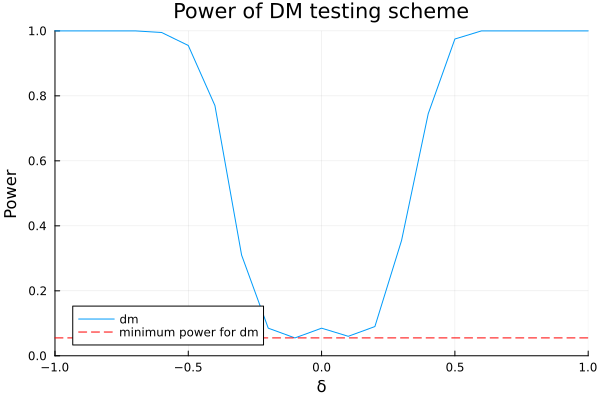

In [9]:
S = 200
n_top, n_bottom = 100, 30

n_boostrap = 100

θ = 0.05
δs = collect(-1.0:0.1:1.0)
power_function_dm = power_dm(δs, n_top, n_boostrap, S, θ)
plot_power_dm = plot(title = "Power of DM testing scheme", xlabel = "δ", ylabel = "Power", xlims=(-1.0, 1.0), ylims = (0.0, 1.0))
plot!(plot_power_dm, δs, power_function_dm, label = "dm")
minimum_power_dm = minimum(power_function_dm)
hline!([minimum_power_dm], color=:red, linestyle=:dash, label="minimum power for dm")
